# Example of using RadioData for training/evaluation
---


## Table of Contents

1. [Data generator for training CFO Correction Network](#cfo_data_generator)
2. [Data generator for training Equalization](#equalization)
3. [Data generator for training Demod + Decoder](#decoder)
4. [Data generator for training End to End](#end2end)

## Environment setup

In [1]:
# Import packages from other direction. Itis necessary if the project is structured as:
# my_project
# ├── notebooks
# │   └── Generate Radio Data for tr.ipynb
# ├── local_python_package
# │   ├── __init__.py
# │   ├── models.py
# ├── README.md
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import multiprocessing as mp
from radioml.dataset import RadioDataGenerator

# For visualization
import imageio
from IPython.display import Image,display
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
sns.set_style("white")

## Define Parameters

In [3]:
NUM_PACKETS  = 10
PREAMBLE_LEN = 40
DATA_LEN     = 200
CHANNEL_LEN = 2
OMEGA      = 1/50
SNR_train  = 10.0 

## Example of data generator for training CFO Correction  <a class="anchor" id="cfo_data_generator"></a>


In [4]:
%%time
radio = RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.cfo_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    [preambles, preambles_conv], cfo_corrected_preamble = one_batch

CPU times: user 214 ms, sys: 55.2 ms, total: 269 ms
Wall time: 1.06 s


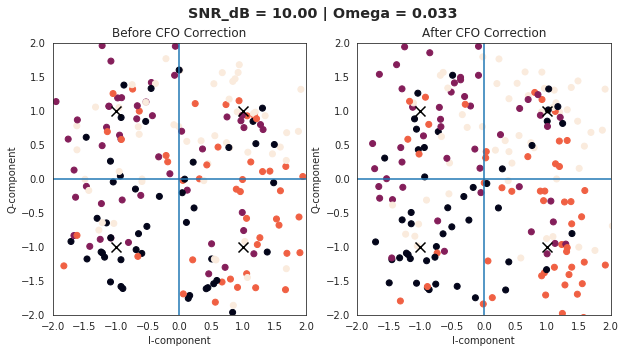

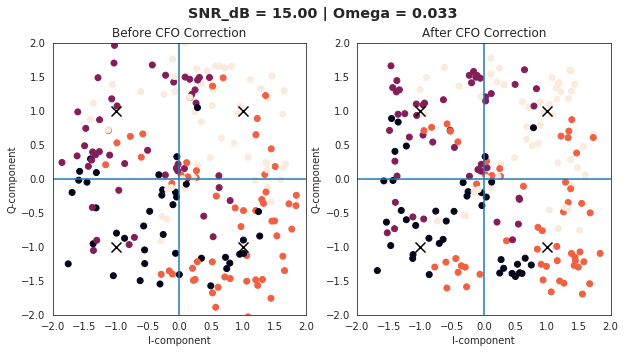

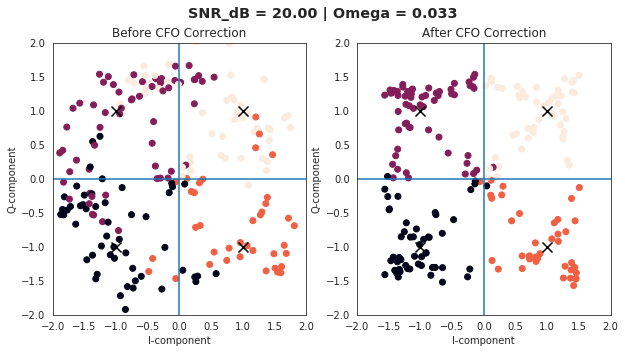

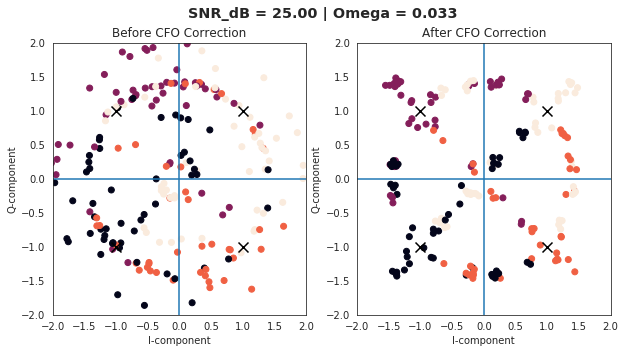

In [5]:
def visualize_cfo(omega, snr):
    
    [preambles, preambles_conv], cfo_corrected_preamble = next(radio.cfo_data_generator(omega, snr, batch_size=5))
    symbols, groundtruths = np.unique(preambles.view(np.complex),return_inverse=True)

    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10,5))
    st = fig.suptitle("SNR_dB = %.2f | Omega = %.3f" % (snr, omega), fontsize="x-large", fontweight='bold')

    left_ax.scatter(preambles_conv[...,0].flatten(),
                    preambles_conv[...,1].flatten(), 
                    c=groundtruths)
    left_ax.scatter(np.real(symbols), np.imag(symbols), marker='x', s=100, color='black')
    
    left_ax.set_xlabel('I-component')
    left_ax.set_ylabel('Q-component')
    left_ax.set_title("Before CFO Correction")
    left_ax.axhline()
    left_ax.axvline()
    left_ax.set_xlim(-2, 2)
    left_ax.set_ylim(-2, 2)

    right_ax.scatter(cfo_corrected_preamble[...,0].flatten(),
                     cfo_corrected_preamble[...,1].flatten(), 
                       c=groundtruths)
    
    right_ax.scatter(np.real(symbols), np.imag(symbols), marker='x', s=100, color='black')
    
    right_ax.set_xlabel('I-component')
    right_ax.set_ylabel('Q-component')
    right_ax.set_title("After CFO Correction")
    right_ax.axhline()
    right_ax.axvline()
    right_ax.set_xlim(-2, 2)
    right_ax.set_ylim(-2, 2)
      # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image


## Visualize data
SNRs = [10.0, 15.0, 20.0, 25.0]

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
_ =imageio.mimsave('./cfo.gif', [visualize_cfo(1/30, snr) for snr in SNRs], fps=1)

In [6]:
from IPython.display import Image,display
display(Image(url='./cfo.gif'))

## Example of data generatorfor training Equalization  <a class="anchor" id="equalization"></a>


In [7]:
%%time
radio = RadioDataGenerator(DATA_LEN,PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.equalization_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    [preambles, cfo_corrected_preamble, cfo_corrected_preamble], channels_etimates = one_batch

CPU times: user 96.5 ms, sys: 69.7 ms, total: 166 ms
Wall time: 917 ms


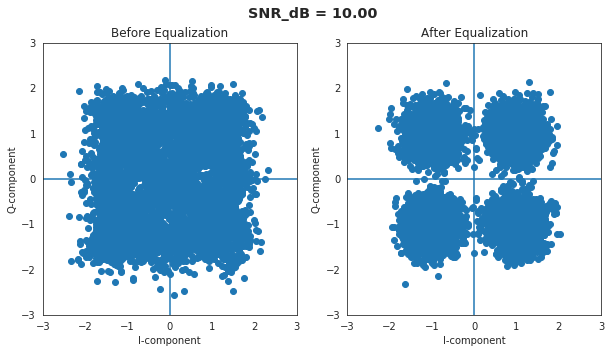

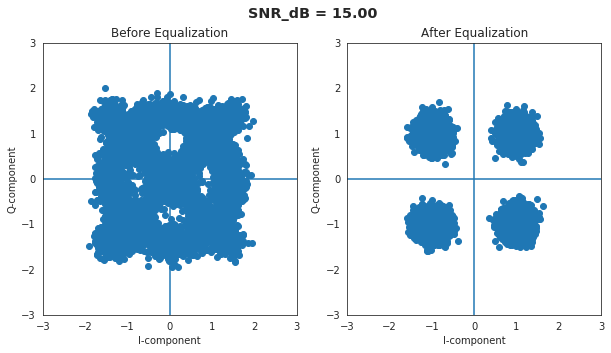

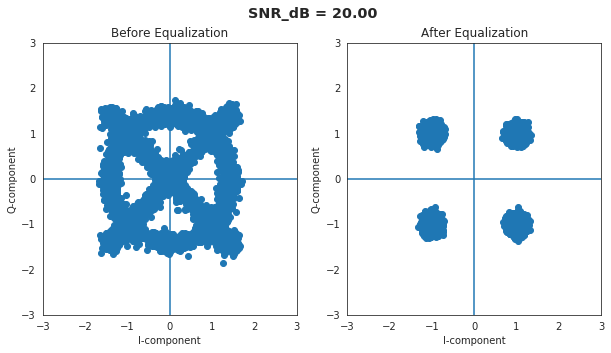

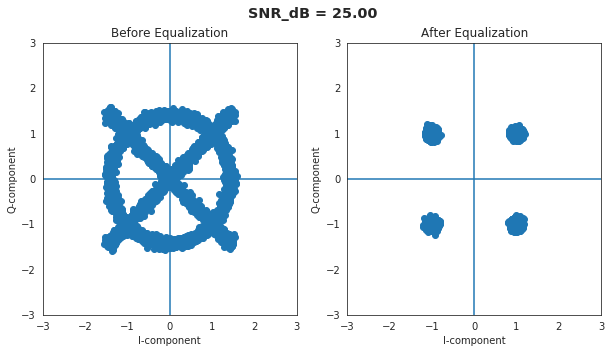

In [8]:
# Visualize a few examples

def visualize_equalization(snr):
    
    examples = next(radio.equalization_data_generator(OMEGA, snr, batch_size=32, num_cpus=8))
    [preambles, cfo_corrected_preamble, cfo_corrected_data], equalized_data = examples
        
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10,5))
    st = fig.suptitle("SNR_dB = %.2f" % snr, fontsize="x-large", fontweight='bold')

    left_ax.scatter(cfo_corrected_data[...,0].flatten(),
                    cfo_corrected_data[...,1].flatten())
    
    left_ax.set_xlabel('I-component')
    left_ax.set_ylabel('Q-component')
    left_ax.set_title("Before Equalization")
    left_ax.axhline()
    left_ax.axvline()
    left_ax.set_xlim(-3, 3)
    left_ax.set_ylim(-3, 3)

    right_ax.scatter(equalized_data[...,0].flatten(),
                     equalized_data[...,1].flatten())
        
    right_ax.set_xlabel('I-component')
    right_ax.set_ylabel('Q-component')
    right_ax.set_title("After Equalization")
    right_ax.axhline()
    right_ax.axvline()
    right_ax.set_xlim(-3, 3)
    right_ax.set_ylim(-3, 3)
      # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

SNRs = [10.0, 15.0, 20.0, 25.0]

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
_ =imageio.mimsave('./equalization.gif', [visualize_equalization(snr) for snr in SNRs], fps=1)

In [9]:
from IPython.display import Image,display
display(Image(url='./equalization.gif'))

## Data generator for training Demod + Decoder <a class="anchor" id="decoder"></a>

In [10]:
%%time
radio = RadioDataGenerator(DATA_LEN, PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.ecc_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    equalized_data, data_estimate = one_batch

CPU times: user 78.5 ms, sys: 66.3 ms, total: 145 ms
Wall time: 800 ms


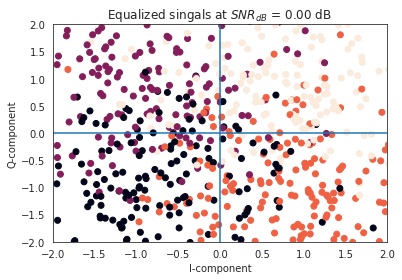

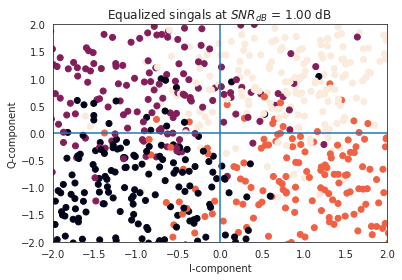

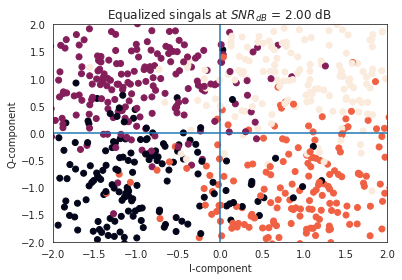

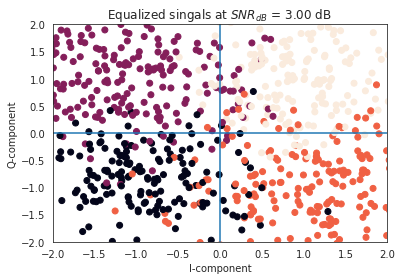

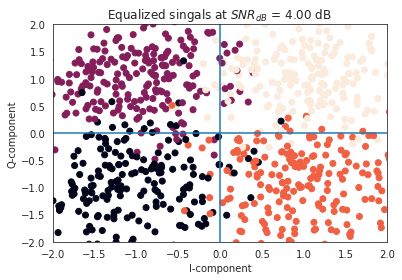

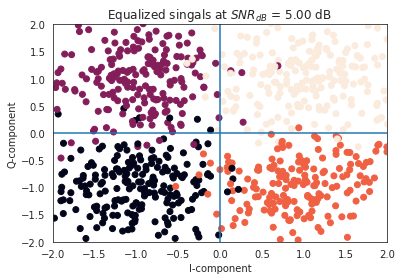

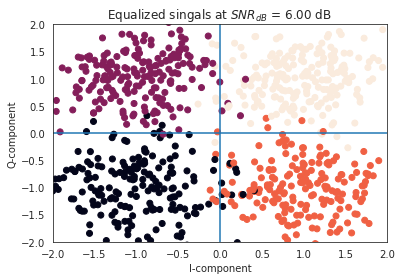

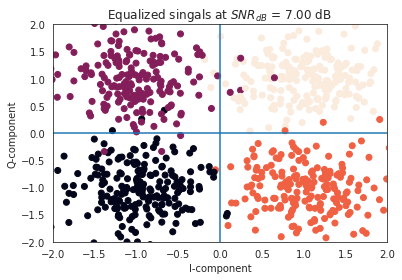

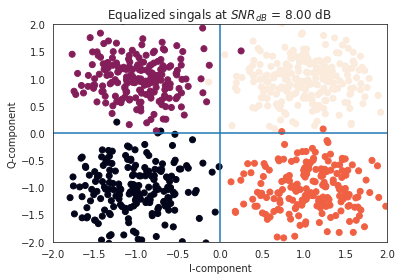

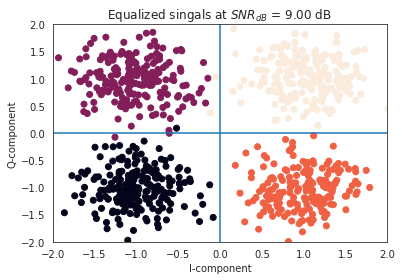

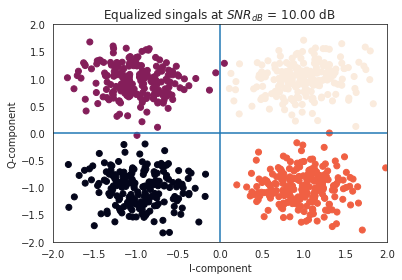

In [11]:
def visualize_demod_n_decode(snr, omega=1/1000):
    [equalized_data, modulated_data], data_estimate = next(radio.ecc_data_generator(omega, snr, batch_size=4))
    symbols, groundtruths = np.unique(modulated_data.view(np.complex), return_inverse=True)
    fig, ax = plt.subplots(1, 1)

    equalized_complex = equalized_data.view(np.complex)
    plt.scatter(np.real(equalized_complex).flatten(),
                np.imag(equalized_complex).flatten(),
                c=groundtruths)
    
    plt.xlabel('I-component')
    plt.ylabel('Q-component')
    plt.title("Equalized singals at $SNR_{dB}$ = %.2f dB " % (snr))
    plt.axhline()
    plt.axvline()
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
      # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

kwargs_write = {'fps':0.5, 'quantizer':'nq'}
SNRs = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
_ =imageio.mimsave('./error_correction.gif', 
                   [visualize_demod_n_decode(snr) for snr in SNRs], fps=1)

In [12]:
from IPython.display import Image,display
display(Image(url='./error_correction.gif'))

## Data generator for training End to End Net <a class="anchor" id="end2end"></a>

In [13]:
%%time
radio = RadioDataGenerator(DATA_LEN,PREAMBLE_LEN, CHANNEL_LEN, modulation_scheme='QPSK')
generator = radio.end2end_data_generator(OMEGA, SNR_train, batch_size=32)

for i in range(3):
    one_batch = next(generator)
    [preambles, corrupted_packets], data_etimates = one_batch

CPU times: user 73.4 ms, sys: 78.2 ms, total: 152 ms
Wall time: 684 ms
